# Project 1, Part 5, Best Customer Analytics

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: PRAKASH KRISHNAN

Year: 2021-2022

Semester: SPRING 2022

Section: WBL 011


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

# Connect to the Postgres database¶
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# Create a cursor for the connection
cursor = connection.cursor()


# Format float displays in a dataframe
pd.options.display.float_format = '$ {:,.2f}'.format

# Create a one time SQL View between stores and sales table for querries in this notebook

connection.rollback()

query = """

drop view if exists v_join_s_sa;

create view v_join_s_sa
as
select s.store_id,
       s.street as store_street,
       s.city as store_city,
       s.state as store_state,
       s.zip as store_zip,
       s.latitude as store_latitude,
       s.longitude as store_longitude,
       sa.sale_id,
       sa.customer_id,
       sa.sale_date,
       extract(dow from sa.sale_date) as dow,
       to_char(sa.sale_date, 'Day') as day_of_week,
       extract(month from sa.sale_date) as month_number,
       to_char(sa.sale_date, 'Month') as month_name,
       sa.total_amount
from stores s
     join sales as sa
        on s.store_id = sa.store_id
;

"""

cursor.execute(query)

connection.commit()

## The executives want you to come up with a high level design of a model, in the form of written criteria, to determine who the best customers are. 

## You do NOT have to code the model. 

## You do NOT have to give an actual list of best customers. 

## Create an executive summary explaining your model. You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

# Executive Summary

No single measure can adquately define the true value of a "Best Customer". 

It is a common practice to define a best customer along the following measures:

**Monetary Value** - Highest dollar sales that the customer has generated in a period (typically a year)<br>
**Frequency** - Frequency of customer purchases<br>
**Recency** - Measure of near-term purchases<br>
**Breadth of Sales** - Measure of different products being purchased<br>
**First Time Customers** - Ability to attract new customers<br>


1. **Highest Annual Dollar Sales-**

Customers that have generated the most dollar sales for AGM during 2020 represent most valued customer for AGM. An example of this is provided as Table 1, showing the top 5 customers with highest $ sales. The relationship with these customers must be maintained and enhanced to ensure continued loyalty to the business.

2. **Highest Number of Sales Transactions-**

This measure is a proxy for Frequency and how often a customer comes back for a repeat purchase. These customers are an important indicator of customer satisfaction and should be nurtured. An example of this measure is provided in Table 2. This measure of frequency ensures satisfied customers keep coming back to do business and these customers provided feedback on areas to improved and enhance.

3. **Highest Sales in Second-Half 2020-**

This measure represents recency that is customers who have puchased recently. 6 Months is used as a benchmark given the month to month deviations. An example is shown in Table 3. 

4. **Highest Complementary Products-**

Customers that buy a broad portfolio are also important as they represent customers fully invested in the AGM business. This is a measure of breadth of product penetration within a customer. Table 5 is an example.

5. **First Time Customers-**
This is a key indicator for future growth and continued expansion of the business. The data is not available for prior years and hence no estimate can be made whether the 2020 customers were new or repeat customers.

Different audiences within a company may be interested in one or more measures as appropriate. It is fairly common to develop a composite measure that combines the constructs as defined above and derive an overall score for a customer. 

**Recommendations for Management:**
1. Develop a balanced score card for "best customer" as defined above and look at top x customers for each category.
2. The score card can reviewed on a quarterly basis for learnings, best practices.
3. The score card can be reviewed nationally or regionally as appropriate.

In [3]:
# Query to determine top 5 customers with highest annual $ sales

rollback_before_flag = True
rollback_after_flag = True

query = """

select customers.customer_id, customers.first_name, customers.last_name, customers.state, 
customers.city, sum(sales.total_amount) as annual_sales

from customers
    join sales
        on customers.customer_id = sales.customer_id

group by customers.customer_id, customers.last_name, customers.first_name
order by annual_sales desc, customers.last_name, customers.first_name

limit 5

"""
print("*********************************************************")
print(" Table 1: Top 5 Customers with Highest Annual Sales $             ")
print("*********************************************************")

df1=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df1

*********************************************************
 Table 1: Top 5 Customers with Highest Annual Sales $             
*********************************************************


,customer_id,first_name,last_name,state,city,annual_sales
0,30772,Marthena,Hrinchishin,TN,Franklin,8328
1,30775,Howey,Di Dello,TN,Franklin,7908
2,30692,Benjamen,Eva,TN,Franklin,7860
3,30323,Wilbur,Garvie,TN,Old Hickory,7848
4,27762,Jenelle,Goretti,TN,Nashville,7848


In [12]:
# Query to determine top 5 customers with highest sales transactions

rollback_before_flag = True
rollback_after_flag = True

query = """

select customers.customer_id, customers.first_name, customers.last_name, customers.state, 
customers.city, count(sales.sale_id) as numb_sales_transactions

from customers
    join sales
        on customers.customer_id = sales.customer_id

group by customers.customer_id, customers.last_name,customers.first_name
order by numb_sales_transactions desc, customers.last_name, customers.first_name

limit 5
"""
print("*******************************************************************")
print(" Table 2: Top 5 Customers with Highest Number of Sales Transactions")
print("*******************************************************************")

df2=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df2

*******************************************************************
 Table 2: Top 5 Customers with Highest Number of Sales Transactions
*******************************************************************


,customer_id,first_name,last_name,state,city,numb_sales_transactions
0,28918,Liuka,Oseman,TN,Nashville,123
1,27728,Gus,Haliburton,TN,Nashville,122
2,27674,Anjela,Millichap,TN,Nashville,120
3,27762,Jenelle,Goretti,TN,Nashville,119
4,27471,Carma,Malone,TN,Nashville,119


In [37]:
# Query to determine top 5 customers with highest sales in H2-2020

rollback_before_flag = True
rollback_after_flag = True

query = """

select sales.customer_id,
       customers.first_name,
       customers.last_name,
       sum(sales.total_amount) as h2_sales 
       
from sales

join
    customers
        on customers.customer_id=sales.customer_id

where sales.sale_date between '2020-07-01' and '2020-12-31'

group by sales.customer_id, customers.last_name, customers.first_name
order by h2_sales desc, customers.last_name, customers.first_name

limit 5

"""

print("*******************************************************************")
print(" Table 3: Top 5 Customers with Highest $ H2-2020 Sales             ")
print("*******************************************************************")


df3=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df3

*******************************************************************
 Table 3: Top 5 Customers with Highest $ H2-2020 Sales             
*******************************************************************


,customer_id,first_name,last_name,h2_sales
0,28543,Marmaduke,Sherebrooke,4668
1,30595,Felix,Kohlerman,4584
2,30323,Wilbur,Garvie,4536
3,30225,Lavina,Baudinot,4524
4,27928,Rozina,Bentke,4488


In [43]:
# Query to determine top 5 customers with most complementary meals

rollback_before_flag = True
rollback_after_flag = True

query = """


select temp_tbl.customer_id, temp_tbl.last_name, temp_tbl.first_name, temp_tbl.city,temp_tbl.state,
count(*) as meal_count from

(select distinct customers.customer_id, customers.first_name, customers.last_name, customers.city, customers.state, 
products.description

from customers

join sales
on customers.customer_id=sales.sale_id

join line_items
on sales.store_id = line_items.store_id and sales.sale_id = line_items.sale_id

join products
on line_items.product_id = products.product_id) as temp_tbl

group by customer_id, temp_tbl.last_name, temp_tbl.first_name, temp_tbl.city, temp_tbl.state
order by meal_count desc, temp_tbl.last_name, temp_tbl.first_name

limit 5


"""

print("*******************************************************************")
print(" Table 4: Top 5 Customers with Highest Complementary Meal          ")
print("*******************************************************************")


df4=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df4

*******************************************************************
 Table 4: Top 5 Customers with Highest Complementary Meal          
*******************************************************************


,customer_id,last_name,first_name,city,state,meal_count
0,29811,Abatelli,Winifred,Madison,TN,8
1,1706,Abbati,Roda,Oakland,CA,8
2,8054,Abbatucci,Algernon,San Mateo,CA,8
3,17666,Abbatucci,Juliann,Dallas,TX,8
4,8930,Abbey,Rabbi,Seattle,WA,8


## Best Customer Analytics Data Visualization

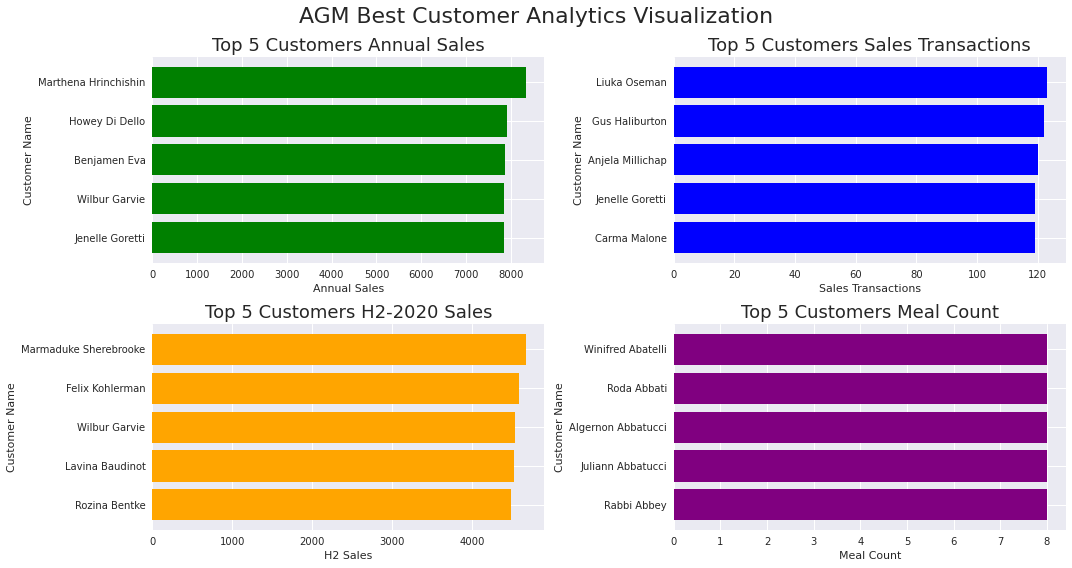

In [57]:
plt.style.use('seaborn')

sales = df1['annual_sales']
customer1 = df1['first_name']+" "+df1['last_name']

numb_of_transactions = df2['numb_sales_transactions']
customer2 = df2['first_name']+" "+df2['last_name']

h2_2020_sales = df3['h2_sales']
customer3 = df3['first_name']+" "+df3['last_name']

annual_meal_count = df4['meal_count']
customer4 = df4['first_name']+" "+df4['last_name']


fig,ax = plt.subplots(2,2,figsize=(15,8))

fig.suptitle('AGM Best Customer Analytics Visualization', fontsize=22)

ax[0][0].barh(customer1, sales, label='highest $ sales',color='green')
ax[0][0].set_title("Top 5 Customers Annual Sales", fontsize=18)
ax[0][0].set_ylabel('Customer Name')
ax[0][0].set_xlabel('Annual Sales')
ax[0][0].invert_yaxis()

ax[0][1].barh(customer2, numb_of_transactions, label='highest # of transactions',color='blue')
ax[0][1].set_title("Top 5 Customers Sales Transactions", fontsize=18)
ax[0][1].set_ylabel('Customer Name')
ax[0][1].set_xlabel('Sales Transactions')
ax[0][1].invert_yaxis()

ax[1][0].barh(customer3, h2_2020_sales, label='highest h2 sales',color='orange')
ax[1][0].set_title("Top 5 Customers H2-2020 Sales", fontsize=18)
ax[1][0].set_ylabel('Customer Name')
ax[1][0].set_xlabel('H2 Sales')
ax[1][0].invert_yaxis()

ax[1][1].barh(customer4, annual_meal_count, label='highest meal counr',color='purple')
ax[1][1].set_title("Top 5 Customers Meal Count", fontsize=18)
ax[1][1].set_ylabel('Customer Name')
ax[1][1].set_xlabel('Meal Count')
ax[1][1].invert_yaxis()

plt.tight_layout()
plt.show()
